# KarpovGuide

Демонстрационный ноутбук чат-бота в рамках тестового задания для симулятора karpov.courses.

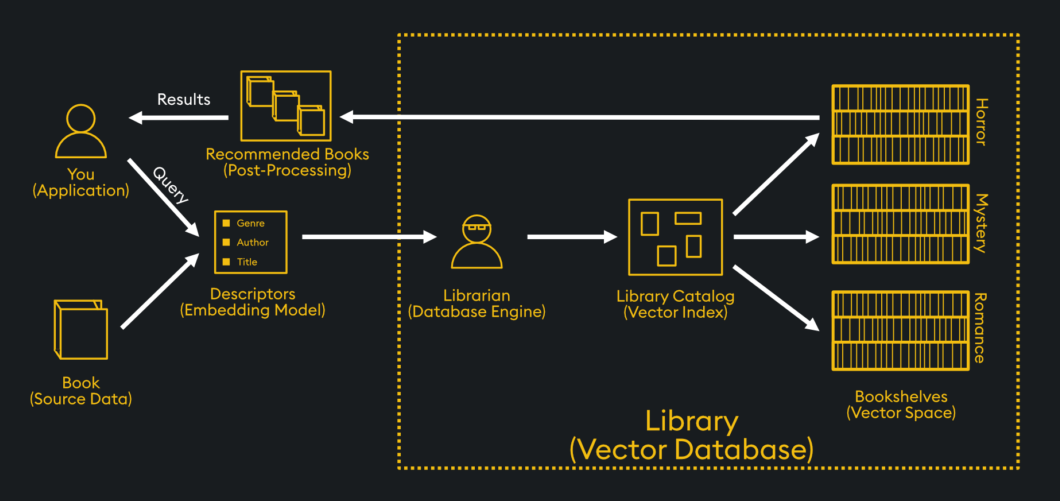
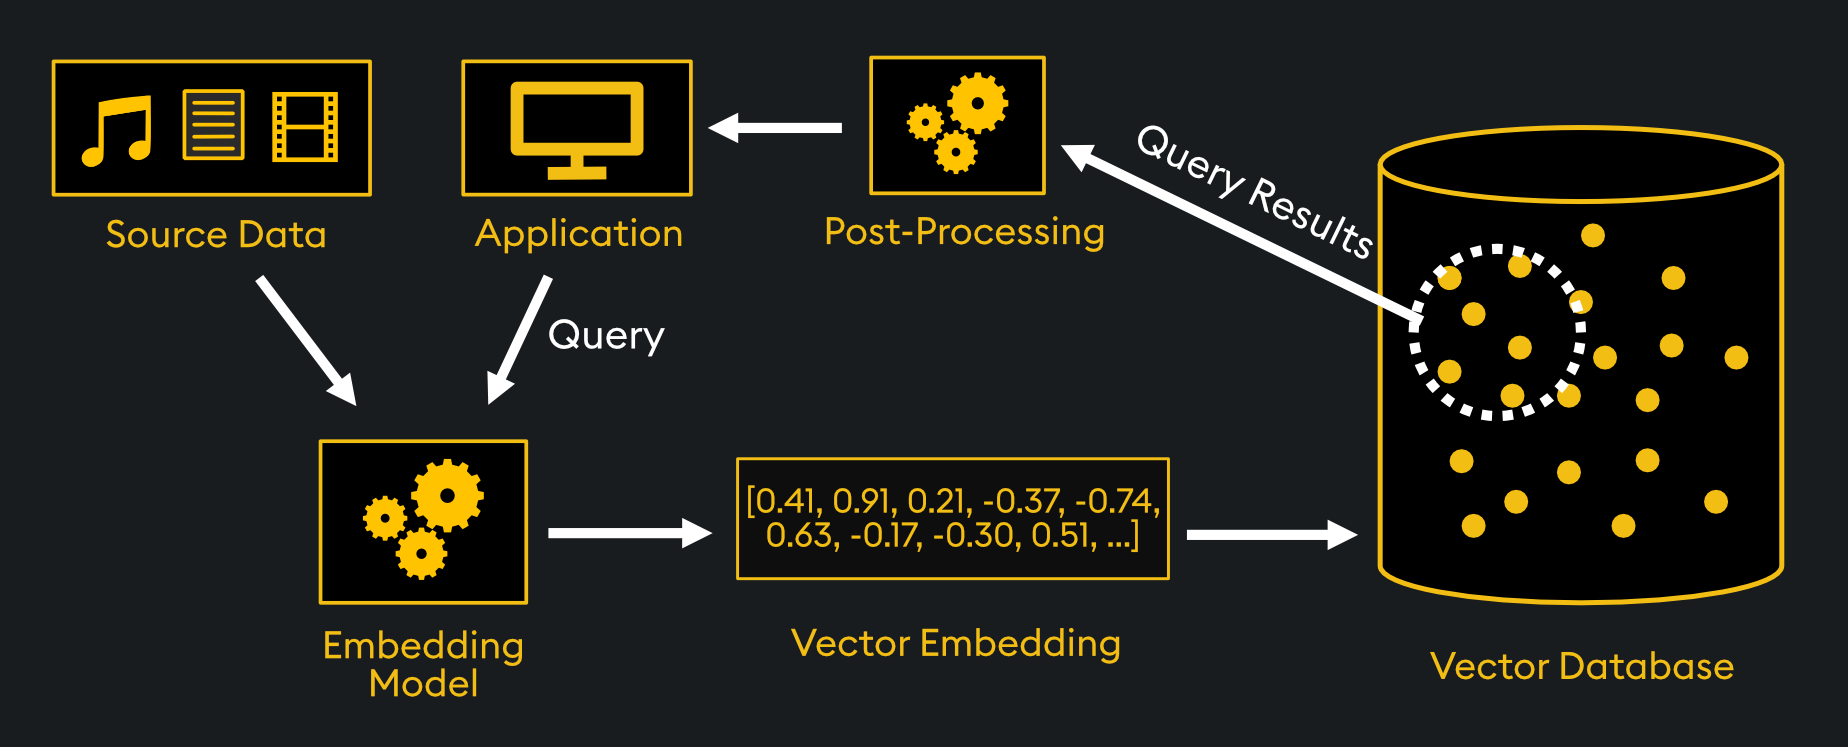
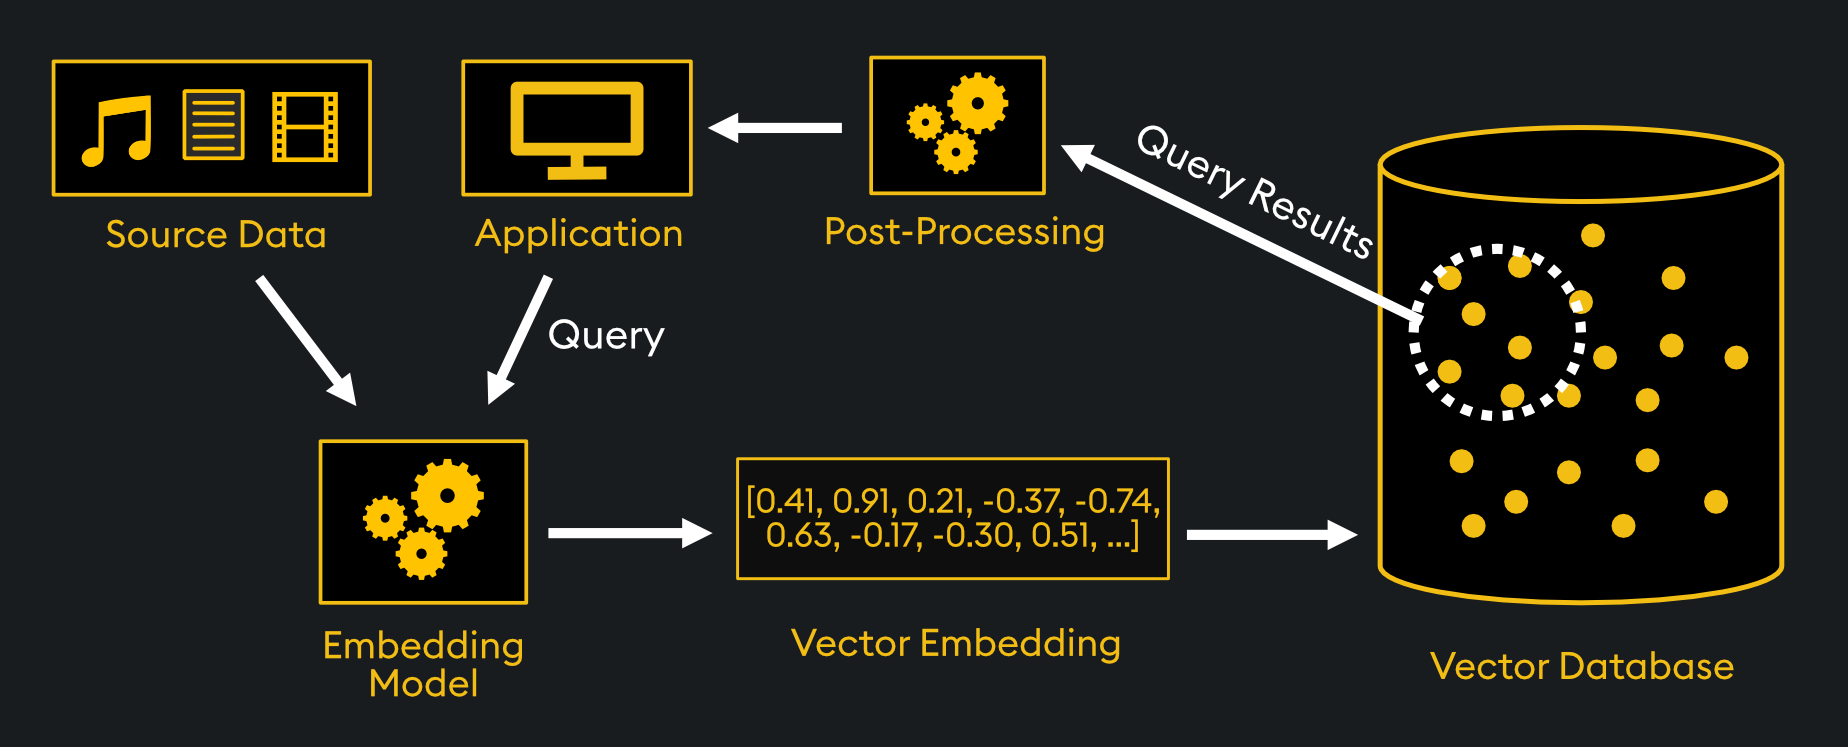

## Установка требуемых библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install sentence-transformers==3.3.1 -q
!pip install qdrant-client==1.13.2 -q
!pip install langchain-community==0.3.16 -q
!pip install langchain-mistralai==0.2.4 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 87.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 5.29.3 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=

# Парсинг karpov.courses

В этой части мы спарсим FAQ с каждой страницы курса, а так же спарсим основную информацию, которая укрывается под тегом 'tn-atom'. Так как по большей части информация неструктурированная, то мы используем zero-shot-классификатор для классификации отдельных абзацов, которые мы спарсим. После этого мы сделаем две коллекции - для FAQ и для общей информации о курсе.

## Парсинг ссылок на курсы

С начала с помощью requests зайдём на главную страницу сайтов с курсами и с помощью bs4 спарсим их, сохраним в отдельный список urls.

In [3]:
import torch
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [4]:
import requests
from bs4 import BeautifulSoup
from typing import List, Dict, Tuple, Set, Optional
import re


def fetch_course_urls(url: str) -> Set[str]:
    """
    Загружает страницу по заданному URL, извлекает все ссылки с классом 't978__innermenu-link'
    и возвращает множество уникальных URL-адресов, исключая 'https://karpov.courses/dev/qa'.

    Параметры:
    - url (str): URL страницы, с которой необходимо извлечь ссылки.

    Возвращаемое значение:
    - urls (Set[str]): Множество уникальных URL-адресов.

    Пример:
    >>> url = "https://karpov.courses"
    >>> urls = fetch_course_urls(url)
    >>> print(urls)
    """
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all("a", class_="t978__innermenu-link")
        urls = {link['href'] for link in links if link.get('href')}

        # Удаляем ненужный URL
        urls.remove('https://karpov.courses/dev/qa')
        
        return urls
    else:
        print(f"Ошибка при загрузке страницы: {response.status_code}")
        return set()


url = "https://karpov.courses"

urls = sorted(fetch_course_urls(url))
for link in urls:
    print('Найдена ссылка на курс:', link)

Найдена ссылка на курс: https://karpov.courses/analytics
Найдена ссылка на курс: https://karpov.courses/analytics-hard
Найдена ссылка на курс: https://karpov.courses/big-data-analytics
Найдена ссылка на курс: https://karpov.courses/career/guide-ds
Найдена ссылка на курс: https://karpov.courses/data-driven
Найдена ссылка на курс: https://karpov.courses/dataengineer
Найдена ссылка на курс: https://karpov.courses/dataengineer-start
Найдена ссылка на курс: https://karpov.courses/datavisualization
Найдена ссылка на курс: https://karpov.courses/deep-learning
Найдена ссылка на курс: https://karpov.courses/docker
Найдена ссылка на курс: https://karpov.courses/mathsds
Найдена ссылка на курс: https://karpov.courses/ml-engineering
Найдена ссылка на курс: https://karpov.courses/ml-hard
Найдена ссылка на курс: https://karpov.courses/ml-start
Найдена ссылка на курс: https://karpov.courses/pythonzero
Найдена ссылка на курс: https://karpov.courses/simulator
Найдена ссылка на курс: https://karpov.cours

P.S.: стоит иметь ввиду, что курс "Тестирование с нуля" (старая ссылка - https://karpov.courses/dev/qa) прекратил своё существование, потому мы исключим адрес из множества ссылок.

## Парсинг названий курса и FAQ

Так как известно, что зачастую в настоящее время на страницах курсов FAQ состоит из двух частей, которые разделяются кнопкой 'Показать еще', то мы сосчитаем число таких кнопок. Если их число окажется больше нуля, значит, мы парсим последние два фрагмента под классов 't849', в противном случае - один. Почему последние один-два? Потому что примерно на половине сайтов курсов имеется более одного фрагмента под классом 't849', а так как поле с FAQ расположено в конце страницы, то мы и парсим именно последние фрагменты.

In [5]:
def parse_titles(urls: List[str]) -> List[str]:
    """
    Парсит названия курса с заданных URL.

    Параметры:
    - urls (List[str]): Список URL-адресов для парсинга.

    Возвращаемое значение:
    - courses_titles (List[str]): Список названий курсов, извлеченных с сайтов.
    """
    courses_titles = []

    for url in urls:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Ошибка при загрузке страницы: {response.status_code}")
            continue

        soup = BeautifulSoup(response.text, 'html.parser')

        course_title = soup.find('h1', class_="tn-atom")
        course_title = re.split(r'\=|\||\.', course_title.text)[0].strip().replace('\xa0', ' ').replace(':', '')
        courses_titles.append(course_title)

        print(f'Найдена вакансия "{course_title}" с сайта: {url}')

    return courses_titles


courses_titles = parse_titles(urls)

Найдена вакансия "Аналитик данных" с сайта: https://karpov.courses/analytics
Найдена вакансия "Hard Аналитика данных" с сайта: https://karpov.courses/analytics-hard
Найдена вакансия "Аналитика больших данных" с сайта: https://karpov.courses/big-data-analytics
Найдена вакансия "Гид по профессиям в Data Science" с сайта: https://karpov.courses/career/guide-ds
Найдена вакансия "Принятие решений на основе данных" с сайта: https://karpov.courses/data-driven
Найдена вакансия "ИНЖЕНЕР ДАННЫХ" с сайта: https://karpov.courses/dataengineer
Найдена вакансия "Инженер данных с нуля" с сайта: https://karpov.courses/dataengineer-start
Найдена вакансия "Визуализация данных и продвинутое Tableau" с сайта: https://karpov.courses/datavisualization
Найдена вакансия "Deep Learning Engineer" с сайта: https://karpov.courses/deep-learning
Найдена вакансия "DOCKER С НУЛЯ" с сайта: https://karpov.courses/docker
Найдена вакансия "МАТЕМАТИКА ДЛЯ DATA SCIENCE" с сайта: https://karpov.courses/mathsds
Найдена ваканс

In [6]:
def parse_faq(urls: List[str]) -> Dict[str, List[str]]:
    """
    Парсит информацию о FAQ курсов с заданных URL.

    Если FAQ отсутствует, выводится соответствующее сообщение. Также добавляется обработка случая, когда необходимо "показать еще" для загрузки полного FAQ.

    Параметры:
    - urls (List[str]): Список URL-адресов для парсинга.

    Возвращаемое значение:
    - faq_collection (Dict[str, List[str]]): Словарь, где ключ — URL, а значение — список вопросов и ответов.
    """
    faq_collection = {}

    for url in urls:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Ошибка при загрузке страницы: {response.status_code}")
            continue

        soup = BeautifulSoup(response.text, 'html.parser')

        # Проверяем наличие FAQ
        if not any(elem.text.startswith('FAQ') for elem in soup.find_all('h2', class_='tn-atom')):
            print(f'FAQ с {url} не был загружен по причине его отсутствия!')
            continue

        # Получаем элементы FAQ
        elements_descr = soup.find_all('div', class_='t849')
        if any(elem.text.strip() == 'Показать еще' for elem in soup.find_all('button', type='button')):
            elements_descr = elements_descr[-2:]
        else:
            elements_descr = elements_descr[-1:]

        # Извлекаем вопросы и ответы
        result = re.split(r'\s{2,}', ''.join(e.text for e in elements_descr).replace('\xa0', ' '))[1:-1]
        questions_answers = [f'Вопрос: {result[i]}\nОтвет: {result[i + 1]}' for i in range(0, len(result), 2)]

        faq_collection[url] = questions_answers
        print(f'FAQ с {url} загружен успешно!')

    return faq_collection

faq_collection = parse_faq(urls)

FAQ с https://karpov.courses/analytics загружен успешно!
FAQ с https://karpov.courses/analytics-hard загружен успешно!
FAQ с https://karpov.courses/big-data-analytics загружен успешно!
FAQ с https://karpov.courses/career/guide-ds не был загружен по причине его отсутствия!
FAQ с https://karpov.courses/data-driven загружен успешно!
FAQ с https://karpov.courses/dataengineer загружен успешно!
FAQ с https://karpov.courses/dataengineer-start загружен успешно!
FAQ с https://karpov.courses/datavisualization не был загружен по причине его отсутствия!
FAQ с https://karpov.courses/deep-learning загружен успешно!
FAQ с https://karpov.courses/docker не был загружен по причине его отсутствия!
FAQ с https://karpov.courses/mathsds загружен успешно!
FAQ с https://karpov.courses/ml-engineering загружен успешно!
FAQ с https://karpov.courses/ml-hard загружен успешно!
FAQ с https://karpov.courses/ml-start загружен успешно!
FAQ с https://karpov.courses/pythonzero загружен успешно!
FAQ с https://karpov.cours

FAQ по двум предметам (по визуализации данных и гид по профессиям) не был загружен, но по причине того, что его просто нет. Идём дальше.

## Парсинг основной информации о курсе

FAQ готов, для него в векторной базе будет создана отдельная коллекция. Теперь будем работать с неструктурированным текстом. Общая информация о курсе содержится под тэгом 'div', классом 'tn-atom' и параметром field='tn_text_{числа}'. Мы спарсим такую информацию, затем, так как зачастую текст с разной по смыслу информацией разделяется управляющими конструкциями '\n', что при сплитовании показывается в виде пустой строчки '', то при сплитовании мы сконкатенируем отдельные фрагменты текста и разделим абзацами между собой, если между абзацами встречается пустая строка.

Так же почистим строки от различного рода мусора. Не будем особо углубляться в обработку текста. Чтобы сделать полноценный чат-бот с диалогом с пользователем, необходима тщательная обработка текста со смысловым разделением, суммаризацией текста, структуризацией (по желанию, это реализуемо, но потребуется сложная модель LLM либо же большое число времени для работы с регулярными выражениями).

In [7]:
def parse_information(urls: List[str]) -> Dict[str, List[str]]:
    """
    Парсит информацию о курсах с заданных URL. Извлекает текстовые блоки с информацией о курсе,
    удаляя лишние символы и форматируя текст в абзацы.

    Параметры:
    - urls (List[str]): Список URL-адресов для парсинга.

    Возвращаемое значение:
    - courses_information (Dict[str, List[str]]): Словарь, где ключ — URL, а значение — список текстовых блоков с информацией о курсе.

    Пример:
    >>> urls = ["http://example.com/course1", "http://example.com/course2"]
    >>> courses_information = parse_courses_information(urls)
    >>> print(courses_information)
    """
    info_collection = {}

    for url in urls:
        response = requests.get(url)
        if response.status_code != 200:
            print(f'Ошибка при загрузке страницы {url}')
            continue

        soup = BeautifulSoup(response.text, 'html.parser')
        result = soup.find_all('div', class_='tn-atom', field=re.compile('tn_text_\d+'))

        sequence, ready_res = '', []
        for elem in result:
            text = elem.text.strip()
            if text:
                sequence += text.translate({160: ' ', 65279: ' ', 10145: ' '}).replace('\u2009', '').replace('1. 2. 3. 4. 5.', '') + ' '
            else:
                ready_res.append(sequence)
                sequence = ''

        info_collection[url] = [res.strip() for res in ready_res if len(res) > 250]

        # если вышло, что у нас всего один абзац, и ничего не добавилось в информацию о курсе
        if not info_collection[url]:
            info_collection[url] = [sequence]

        print(f'Информация с {url} загружена успешно.')

    return info_collection


info_collection = parse_information(urls)

Информация с https://karpov.courses/analytics загружена успешно.
Информация с https://karpov.courses/analytics-hard загружена успешно.
Информация с https://karpov.courses/big-data-analytics загружена успешно.
Информация с https://karpov.courses/career/guide-ds загружена успешно.
Информация с https://karpov.courses/data-driven загружена успешно.
Информация с https://karpov.courses/dataengineer загружена успешно.
Информация с https://karpov.courses/dataengineer-start загружена успешно.
Информация с https://karpov.courses/datavisualization загружена успешно.
Информация с https://karpov.courses/deep-learning загружена успешно.
Информация с https://karpov.courses/docker загружена успешно.
Информация с https://karpov.courses/mathsds загружена успешно.
Информация с https://karpov.courses/ml-engineering загружена успешно.
Информация с https://karpov.courses/ml-hard загружена успешно.
Информация с https://karpov.courses/ml-start загружена успешно.
Информация с https://karpov.courses/pythonzero 

In [8]:
for url in info_collection.keys():
    print('URL:', url, 'INFO:', info_collection[url][0][:50], 'число абзацев:', len(info_collection[url]))

URL: https://karpov.courses/analytics INFO: Освойте востребованную профессию за 5 месяцев СТАР число абзацев: 8
URL: https://karpov.courses/analytics-hard INFO: Повысьте грейд за 6 месяцев СТАРТ ПОТОКАСКОРО ПОЯВ число абзацев: 4
URL: https://karpov.courses/big-data-analytics INFO: Старт обучения1 сентября 2025 года ФОРМАТ ОБУЧЕНИЯ число абзацев: 6
URL: https://karpov.courses/career/guide-ds INFO: > Узнаете больше о сферах и направлениях в Data Sc число абзацев: 1
URL: https://karpov.courses/data-driven INFO: СТАРТ ПОТОКА31 ОКТЯБРЯ практика 7 ПРОЕКТОВ ФОРМАТО число абзацев: 7
URL: https://karpov.courses/dataengineer INFO: Инженерия данных от проектирования до нетривиально число абзацев: 5
URL: https://karpov.courses/dataengineer-start INFO: > Освойте востребованную профессию инженера данных число абзацев: 6
URL: https://karpov.courses/datavisualization INFO: > Освойте основы дизайна и работы в Tableau> Улучш число абзацев: 4
URL: https://karpov.courses/deep-learning INFO: > Узнайте, как

Пока что это плохо структурированный и временами нечитабельный текст, но так как NLP-модели зачастую работают с n-граммами, то они способны уловить общий смысл, если модель посчитает их за знакомые. Обработка текста до оптимального вида займёт очень много времени, поэтому пропустим этот шаг.

### Классификация общей информации после парсинга

Используем метод pipeline из библиотеки transformers и запустим процедуру zero-shot-классификации, чтобы структурировать нашу информацию о курсах по смыслу для дальнейшего разбития на чанки. Таким образом мы сможем хоть как-то придать структуру нашим огромным текстам.await

In [9]:
from transformers import pipeline, logging

logging.set_verbosity_error()


def classify_sequence(text: str) -> Tuple[List[str], List[float]]:
    """
    Классифицирует входной текст с использованием модели zero-shot классификации для назначения меток.
    
    Функция использует модель `cointegrated/rubert-base-cased-nli-threeway` для классификации текста по заданному списку категорий (меток).
    Возвращает список категорий и их соответствующие вероятности для заданного текста.
    
    Параметры:
    - text (str): Входной текст, который нужно классифицировать. Это может быть описание курса, вопрос или любой другой текст.
    
    Возвращаемое значение:
    - Tuple[List[str], List[float]]: Кортеж, где первый элемент — список меток, присвоенных тексту, а второй — список вероятностей для каждой метки.
    """
    
    classifier = pipeline(
        "zero-shot-classification", 
        model="cointegrated/rubert-base-cased-nli-threeway",
        device=(0, -1)[device == 'cpu']
    )
    
    candidate_labels = [
    "Информация о старте потока",
    "Практика и проекты",
    "Содержание курса",
    "Описание обучаемой вакансии",
    "Авторы курса и продолжительность уроков",
    "Карьера и трудоустройство",
    "Материалы курса",
    "Целевая аудитория",
    "Тарифы и рассрочки",
    "Гарантии и возврат средств",
    "Выпускники курса"
]
    
    output = classifier(text, candidate_labels, multi_label=True)
    result = []

    for category, score in zip(output['labels'], output['scores']):
        if score > 0.8:
            result.append(category)
            
    # если нет отсеянных категорий
    if not result:
        result = ['Прочая информация']
        
    return result

Протестируем работу модели.

In [10]:
sequence = info_collection['https://karpov.courses/ml-start'][0]

print('Классы:', *classify_sequence(sequence))
print()
print('Текст:', sequence)

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Классы: Практика и проекты Содержание курса Информация о старте потока Карьера и трудоустройство Материалы курса Описание обучаемой вакансии

Текст: > Погрузитесь в сферу Machine Learning и освойте одну из самых востребованных профессий в IT до уровня junior СТАРТ ПОТОКА13 февраля Подготовка к работе в реальных условиях Реальные проекты в вашем портфолио Разбор задач с собеседований Карьерная помощь Авторыэксперты индустрии Форматонлайн длительность7 месяцев Мы свяжемся с вами и ответим на все ваши вопросы по курсу. Деятельность ML-инженеров объединяет анализ данных и разработку Они создают модели машинного обучения, которые предсказывают события и автоматически принимают решения в самых разных областях. Анализ данных для постановки диагноза или предупреждения заболевания Прогнозы на курс валют или динамику взаимодействия клиента с банком Оценка эффективности каналов продвижения, персонализация рекламы, поиск точек роста бизнеса Контроль качества продукции, оптимизация затрат На 433% в

Модель достаточно логично распределяет вероятности принадлежности к классам. Так как у нас встречаются огромные тексты по 5000 символов и выше, то разделим текст на фрагменты, например, по 1500 символов.

In [11]:
import re
from tqdm.notebook import tqdm
#from tqdm import tqdm


def split_text(text: str, piece_size: int = 1500, min_length: int = 2000) -> List[str]:
    """
    Разбивает длинный текст на меньшие части, каждая из которых не превышает заданный размер. 
    Если текст короче минимальной длины, возвращает его целиком.

    Параметры:
    - text (str): Исходный текст, который необходимо разделить на фрагменты.
    - piece_size (int): Максимальная длина каждого фрагмента (по умолчанию 1500 символов).
    - min_length (int): Минимальная длина текста, при которой он не будет разделен на фрагменты (по умолчанию 2000 символов).

    Возвращаемое значение:
    - List[str]: Список частей текста. Каждая часть — это строка текста длиной не более `piece_size` символов.
    """
    if len(text) < min_length:
        return [text]

    text_pieces = []
    current_piece = ""

    sentences = re.split(r'(?<=\.) ', text)

    for sentence in sentences:
        if len(current_piece) + len(sentence) + 1 <= piece_size:
            current_piece += sentence + " "
        else:
            text_pieces.append(current_piece.strip())
            current_piece = sentence + " "

    if current_piece:
        text_pieces.append(current_piece.strip())

    return text_pieces

In [12]:
def classify_info(info_collection: Dict[str, List[str]]) -> Dict[str, List[Dict[str, List[str]]]]:
    """
    Классифицирует текстовую информацию для каждого курса, деля длинные тексты на части и классифицируя их с использованием модели.
    
    Функция обрабатывает коллекцию текстов, классифицирует каждый текст (или его часть, если текст слишком длинный) 
    и сохраняет результат в структуру данных, где каждый URL будет связан с классифицированными частями текста.

    Параметры:
    - info_collection (Dict[str, List[str]]): Словарь, где ключом является URL курса, а значением — список текстов (или описаний), которые нужно классифицировать.
    
    Возвращаемое значение:
    - Dict[str, List[Dict[str, List[str]]]]: Возвращает словарь, где ключами являются URL курса, а значениями — списки словарей, 
      каждый из которых содержит текст (или его часть) и список категорий, присвоенных этому тексту.
    """
    info_collection_classified = dict()
    
    # Определяем общее количество сегментов для tqdm
    total_sequences = sum(len(texts) for texts in info_collection.values())
    
    with tqdm(total=total_sequences, desc="Классификация текстов") as pbar:
        for url, sequences in info_collection.items():
            for seq in sequences:
                pieces = split_text(seq) if len(seq) > 2000 else [seq]
                
                for piece in pieces:
                    seq_categories = ', '.join(classify_sequence(piece))
                    classified_piece = {
                        'sequence': piece,
                        'categories': seq_categories
                    }
                    info_collection_classified.setdefault(url, []).append(classified_piece)
                pbar.update(1)
    
            pbar.set_description(f"Обработан URL: {url.split('/')[-1]}")
            
    return info_collection_classified

info_collection_classified = classify_info(info_collection)

Классификация текстов:   0%|          | 0/86 [00:00<?, ?it/s]

Далее разделим наши классифицрованные абзацы на чанки с помощью функции chunk_text_by_len.

# SBERT + Qdrant - создание векторной базы, векторизация и индексация

Займёмся теперь настройкой векторной базы данных Qdrant. Почему Qdrant? Во-первых, она предлагает удобный API, один бесплатный кластер на 1 GB, удобное индексирование и поддерживает стабильную работу внутри ноутбуков (Kaggle Notebook, Google Colab).

В качестве vectorizer выберем предобученную модель Sentence-BERT, а именно 'DeepPavlov/rubert-base-cased-sentence'.

In [13]:
import pandas as pd
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from qdrant_client.models import PointStruct
from sentence_transformers import SentenceTransformer

In [14]:
qdrant_client = QdrantClient(
    url="https://e4a0270f-59cd-453d-9577-e33637c4ec29.us-east4-0.gcp.cloud.qdrant.io",
    api_key="gBVNUkVt2u7Mr-z5NcJnO4OX5gV2a6ztLW7nDvNrMupS5Mez1kNpZw"
)

print("Successfully connected to Qdrant!")

Successfully connected to Qdrant!


In [15]:
model = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence').to(device)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
сourse_vector_length = model.encode(faq_collection['https://karpov.courses/dataengineer-start'][0], show_progress_bar=False).shape[0]

print(f'Вектор имеет длину {сourse_vector_length}')

Вектор имеет длину 768


In [17]:
courses_df = pd.DataFrame({'course_name': courses_titles, 'course_url': info_collection_classified.keys()})
display(courses_df)

,course_name,course_url
0,Аналитик данных,https://karpov.courses/analytics
1,Hard Аналитика данных,https://karpov.courses/analytics-hard
2,Аналитика больших данных,https://karpov.courses/big-data-analytics
3,Гид по профессиям в Data Science,https://karpov.courses/career/guide-ds
4,Принятие решений на основе данных,https://karpov.courses/data-driven
5,ИНЖЕНЕР ДАННЫХ,https://karpov.courses/dataengineer
6,Инженер данных с нуля,https://karpov.courses/dataengineer-start
7,Визуализация данных и продвинутое Tableau,https://karpov.courses/datavisualization
8,Deep Learning Engineer,https://karpov.courses/deep-learning
9,DOCKER С НУЛЯ,https://karpov.courses/docker


In [18]:
def prepare_faq_chunks(faq_collection: Dict[str, List[str]], courses_df: pd.DataFrame, start_id: int = 0) -> List[Dict]:
    """
    Подготавливает чанки для FAQ, извлекая вопросы и ответы с добавлением метаданных для каждого чанка.

    Эта функция принимает коллекцию FAQ для каждого курса и соответствующую информацию о курсах, а затем разбивает
    каждый вопрос и ответ на отдельные чанки с добавлением метаданных, таких как идентификатор курса и индекс вопроса.

    Параметры:
    - faq_collection (Dict[str, List[str]]): Коллекция FAQ, где ключ — это URL курса, а значение — список строк в формате "Вопрос: <text> Ответ: <text>".
    - courses_df (pd.DataFrame): DataFrame, содержащий названия курсов и их URL.
    - start_id (int): Начальный индекс для нумерации чанков. По умолчанию равен 0.

    Возвращаемое значение:
    - List[Dict]: Список чанков, где каждый чанк представляет собой словарь с информацией о вопросах и ответах.
    """
    
    chunks = []
    
    course_names = dict(zip(courses_df['course_url'], courses_df['course_name']))
    
    for course_url, qa_pairs in faq_collection.items():
        course_name = course_names[course_url]
        
        for i, qa_pair in enumerate(qa_pairs, start=start_id):       
            chunk = {
                'chunk_id': f"{course_url.split('/')[-1]}_{i}",
                'course_name': course_name,
                'course_url': course_url,
                'question_and_answer': qa_pair,
                'metadata': {
                    'chunk_type': 'qa',
                    'course_id': course_url.split('/')[-1],
                    'qa_index': i,
                    'total_qa_pairs': len(qa_pairs)
                }
            }
            chunks.append(chunk)
    
    return chunks


def create_faq_embeddings(chunks: List[Dict], batch_size: int = 32) -> np.ndarray:
    """
    Создает эмбеддинги для чанков с батчингом для оптимизации памяти.

    Эта функция преобразует список чанков (вопросов и ответов) в эмбеддинги с использованием модели. 
    Для оптимизации использования памяти эмбеддинги создаются пакетами (batching).

    Параметры:
    - chunks (List[Dict]): Список чанков, каждый из которых должен содержать информацию о вопросе и ответе.
    - batch_size (int): Размер пакета для обработки. По умолчанию равен 32.

    Возвращаемое значение:
    - np.ndarray: Массив эмбеддингов для каждого чанка.
    """
    texts = [chunk['question_and_answer'] for chunk in chunks]
    
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
        embeddings.extend(batch_embeddings)

        print(f'{i} of {len(texts)} FAQ is done!')
    
    embeddings = np.array(embeddings)
    return embeddings


def upload_faq_to_qdrant(chunks: List[Dict], embeddings: np.ndarray, collection_name: str = 'karpov-guide-faq', сourse_vector_length: int = 768):
    """
    Загружает данные в Qdrant с оптимизированными параметрами.

    Эта функция загружает чанки текста и их эмбеддинги в коллекцию Qdrant. 
    Если коллекция уже существует, она будет удалена и создана заново.

    Параметры:
    - chunks (List[Dict]): Список чанков, каждый из которых содержит текстовые данные (вопрос, ответ и метаданные).
    - embeddings (np.ndarray): Эмбеддинги для чанков, полученные после векторизации текста.
    - collection_name (str): Название коллекции в Qdrant. По умолчанию 'karpov-guide-faq'.

    Возвращаемое значение:
    - None
    """
    if any(chunks) and embeddings.any():
    
        if qdrant_client.collection_exists(collection_name):
            qdrant_client.delete_collection(collection_name)  # Удаляем, если уже создана
                
        qdrant_client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=сourse_vector_length, distance=Distance.COSINE),
        )
        
        points = []
        for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
            point = PointStruct(
                id=i,
                vector=embedding.tolist(),
                payload={
                    'chunk_id': chunk['chunk_id'],
                    'course_name': chunk['course_name'],
                    'course_url': chunk['course_url'],
                    'question_and_answer': chunk['question_and_answer'],
                    'metadata': chunk['metadata']
                }
            )
            points.append(point)
        
        qdrant_client.upload_points(
            collection_name=collection_name,
            points=points,
            batch_size=30
        )

In [19]:
def prepare_info_chunks(info_collection: Dict[str, List[Dict]], courses_df: pd.DataFrame, start_id: int = 0) -> List[Dict]:
    """
    Подготавливает чанки для основной информации о курсе, включая описание и категории.

    Эта функция принимает коллекцию информации о курсе и соответствующую информацию о курсах, затем разбивает
    данные на отдельные чанки, добавляя метаданные для каждого элемента, такие как идентификатор курса и индекс.

    Параметры:
    - info_collection (Dict[str, List[Dict]]): Коллекция информации о курсах, где ключ — это URL курса, а значение — список словарей с информацией (например, описание, категории).
    - courses_df (pd.DataFrame): DataFrame, содержащий названия курсов и их URL.
    - start_id (int): Начальный индекс для нумерации чанков. По умолчанию равен 0.

    Возвращаемое значение:
    - List[Dict]: Список чанков, где каждый чанк содержит информацию о курсе, включая описание и категории.
    """
    chunks = []
    
    course_names = dict(zip(courses_df['course_url'], courses_df['course_name']))

    for course_url, values in info_collection.items():
        course_name = course_names[course_url]

        for i, elem in enumerate(values, start=start_id):
            chunk = {
                'chunk_id': f"{course_url.split('/')[-1]}_{i}",
                'course_name': course_name,
                'course_url': course_url,
                'sequence': elem['sequence'],
                'categories': elem['categories'],
                'metadata': {
                    'chunk_type': 'course_information',
                    'course_id': course_url.split('/')[-1],
                    'course_information_index': i,
                    'total_sequences': len(values)
                }
            }
            chunks.append(chunk)
    
    return chunks


def create_info_embeddings(chunks: List[Dict], batch_size: int = 32) -> np.ndarray:
    """
    Создает эмбеддинги для чанков с батчингом для оптимизации памяти.

    Эта функция преобразует список чанков информации о курсах в эмбеддинги с использованием модели. 
    Эмбеддинги создаются пакетами для оптимизации использования памяти.

    Параметры:
    - chunks (List[Dict]): Список чанков с информацией о курсах, где каждый чанк содержит описание и категории.
    - batch_size (int): Размер пакета для обработки. По умолчанию равен 32.

    Возвращаемое значение:
    - np.ndarray: Массив эмбеддингов для каждого чанка.
    """
    embeddings = []
    for i in range(0, len(chunks), batch_size):
        batch_texts = [chunk['sequence'] for chunk in chunks[i:i + batch_size]]
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
        embeddings.extend(batch_embeddings)

        print(f'{i} of {len(chunks)} INFORMATION is done!')
    
    embeddings = np.array(embeddings)
    return embeddings


def upload_info_to_qdrant(chunks: List[Dict], embeddings: np.ndarray, collection_name: str = 'karpov-guide-info', сourse_vector_length: int = 768):
    """
    Загружает данные в Qdrant с оптимизированными параметрами.

    Эта функция загружает чанки основной информации о курсах и их эмбеддинги в коллекцию Qdrant. 
    Если коллекция уже существует, она будет удалена и создана заново.

    Параметры:
    - chunks (List[Dict]): Список чанков с основной информацией о курсе, включая описание и категории.
    - embeddings (np.ndarray): Эмбеддинги для чанков, полученные после векторизации текста.
    - collection_name (str): Название коллекции в Qdrant. По умолчанию 'karpov-guide-info'.

    Возвращаемое значение:
    - None
    """
    if any(chunks) and embeddings.any():
        
        if qdrant_client.collection_exists(collection_name):
            qdrant_client.delete_collection(collection_name)  # Удаляем, если уже создана
                
        qdrant_client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=сourse_vector_length, distance=Distance.COSINE),
        )
        
        points = []
        for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
            point = PointStruct(
                id=i,
                vector=embedding.tolist(),
                payload={
                    'chunk_id': chunk['chunk_id'],
                    'course_name': chunk['course_name'],
                    'course_url': chunk['course_url'],
                    'sequence': chunk['sequence'],
                    'categories': chunk['categories'],
                    'metadata': chunk['metadata']
                }
            )
            points.append(point)
        
        qdrant_client.upload_points(
            collection_name=collection_name,
            points=points,
            batch_size=30
        )

In [20]:
qa_chunks = prepare_faq_chunks(faq_collection, courses_df)
info_chunks = prepare_info_chunks(info_collection_classified, courses_df)

In [21]:
qa_embeddings = create_faq_embeddings(qa_chunks)
info_embeddings = create_info_embeddings(info_chunks)

0 of 209 FAQ is done!
32 of 209 FAQ is done!
64 of 209 FAQ is done!
96 of 209 FAQ is done!
128 of 209 FAQ is done!
160 of 209 FAQ is done!
192 of 209 FAQ is done!
0 of 143 INFORMATION is done!
32 of 143 INFORMATION is done!
64 of 143 INFORMATION is done!
96 of 143 INFORMATION is done!
128 of 143 INFORMATION is done!


In [22]:
upload_faq_to_qdrant(qa_chunks, qa_embeddings)
upload_info_to_qdrant(info_chunks, info_embeddings)

In [23]:
def search_similar(query: str, top_k: int = 5) -> List[Tuple[str, object]]:
    """
    Ищет наиболее релевантные чанки в базе данных Qdrant, используя векторное представление запроса.

    Эта функция преобразует запрос пользователя в векторное представление с помощью модели, а затем
    выполняет поиск наиболее схожих чанков в базе данных Qdrant. Возвращает топ-N наиболее релевантных результатов.

    Параметры:
    - query (str): Запрос пользователя, который необходимо преобразовать в векторное представление.
    - top_k (int): Количество возвращаемых результатов. По умолчанию 5.

    Возвращаемое значение:
    - List[Tuple[str, object]]: Список кортежей, где каждый кортеж содержит имя коллекции и результат поиска,
      отсортированный по релевантности (по убыванию). Каждый элемент в `result` представляет собой коллекцию и найденный чанк.

    Пример:
    >>> result = search_similar("Какие курсы по Data Science вы предлагаете?")
    >>> print(result)  # [('karpov-guide-faq', <PointStruct>), ...]
    """
    query_embedding = model.encode(query, show_progress_bar=False)

    all_collections = qdrant_client.get_collections()
    result = []

    for collection in all_collections.collections:
        collection_name = collection.name
        
        search_result = qdrant_client.search(
            collection_name=collection_name,
            query_vector=query_embedding,
            limit=top_k
        )

        for seq in search_result:
            result.append((collection_name, seq))

    result = sorted(result, key=lambda x: x[1].score, reverse=True)
    
    return result

# Выполнение инференсов

In [31]:
def create_rag_prompt(query: str, top_k: int = 5) -> str:
    """
    Создает промпт для генерации ответа с использованием RAG-модели на основе запроса пользователя и релевантных данных из базы.

    Эта функция принимает запрос пользователя, выполняет поиск релевантных чанков информации в базе данных, 
    а затем формирует промпт для языковой модели. Промпт включает в себя как сам запрос, так и контекст из базы данных, 
    упорядоченный по релевантности. Он используется для генерации подробного ответа на запрос пользователя с использованием только 
    предоставленных данных.

    Параметры:
    - query (str): Запрос пользователя, для которого нужно создать промпт.
    - top_k (int): Количество релевантных чанков, которые нужно включить в контекст. По умолчанию 5.

    Возвращаемое значение:
    - str: Промпт для языковой модели, включающий запрос пользователя и релевантный контекст из базы данных.

    Пример:
    >>> query = "Какие курсы по Data Science вы предлагаете?"
    >>> prompt = create_rag_prompt(query, top_k=5)
    >>> print(prompt)
    """
    
    base_prompt = f"""Роль: ты — помощник по курсам Karpov.course, а так же специалист по аналитике данных и Data Science. Твоя задача - помочь пользователю с вопросами о курсах, используя только предоставленную информацию.

    Вопрос пользователя: {query}
    
    Контекст из базы знаний (отсортирован по релевантности):
    """

    end_prompt = """
        На основе предоставленной информации, пожалуйста:
        1. Дай подробный ответ на вопрос пользователя
        2. Укажи конкретные курсы, которые могут быть релевантны запросу
        3. Предоставь ссылки на рекомендуемые курсы

        ПРИ НАЛИЧИИ (если такой информации нет - НЕ ПИШИ НИЧЕГО, а если пользователь просит - ВЕДИ ЕГО НА ССЫЛКУ КУРСА):
        1. Информация об оплате курса
        2. Данные о преподаваемых технологиях
        3. Дата начала курса и его длительность
        
        Важно: 
        - Используй ТОЛЬКО русский язык при ответе на вопрос пользователя
        - Не пиши пользователю ничего про контект, он не должен знать, что у тебя есть контекст
        - Старайся использовать информацию из контекста
        - Если информации недостаточно, скажи пользователю перейти на сайт https://karpov.courses/ или в телеграм-канале https://t.me/+fPqRCFmZS9ZkZDZi
        - Не придумывай факты
        - Не рекомендуй тот же самый курс, о котором ведётся диалог
        - Если у тебя нет какой-то информации в контексте, не пиши это пользователю, вежливо попроси его перейти на сайт с курсом или на главный сайт
        - Всегда указывай источник информации (название курса)"""
    
    results = search_similar(query, top_k=top_k)

    for result in results:

        if 'question' in result[1].payload:
            context_piece = f"""
            [FAQ] Курс: {result[1].payload['course_name']} (ссылка: {result[1].payload['course_url']})
            В: {result[1].payload['question']}
            О: {result[1].payload['answer']}
            """
        else:
            context_piece = f"""
            [Описание] Курс: {result[1].payload['course_name']} (ссылка: {result[1].payload['course_url']})
            {result[1].payload.get('sequence', '')}"""
            
        base_prompt += context_piece

    ready_prompt = base_prompt + end_prompt
    
    return ready_prompt

In [32]:
from langchain_core.messages import HumanMessage
from langchain_mistralai.chat_models import ChatMistralAI
from langchain.memory import ConversationSummaryMemory
from langchain.chains import ConversationChain


def start_messaging(rag_top_k: int = 5, max_memory_size: int = 4096) -> None:
    """
    Запускает чат-бота с использованием модели MistralAI для общения с пользователем, применяя информацию из базы данных 
    с помощью RAG-модели и ограничением на размер памяти.

    Эта функция запускает чат-бота, который получает запросы пользователя, создает промпт с контекстом из базы данных 
    и генерирует ответы с использованием модели MistralAI. Ответы строятся на основе релевантных данных из Qdrant. 
    Контекст чата ограничен максимальным размером памяти.

    Параметры:
    - rag_top_k (int): Количество наиболее релевантных чанков, которые будут использованы для создания контекста запроса. По умолчанию 5.
    - max_memory_size (int): Максимальный размер памяти для истории чата. По умолчанию 4096.

    Возвращаемое значение:
    - None

    Пример:
    >>> start_messaging()
    """
    llm = ChatMistralAI(
        model="mistral-small-latest", 
        api_key='Rwfanxaxljkr1MRPcb0L9ogDf0e81zQf',
        streaming=True
    )
    
    conversation = ConversationChain(
        llm=llm,
        memory=ConversationSummaryMemory(llm=llm),
        verbose=False
    )
    
    print("Диалог начат. Введите сообщение, чтобы продолжить общение. Для выхода введите 'выход'.")
    
    memory_size = 0

    while True:
        user_input = input("Ты: ")
                
        if user_input.lower() == 'выход':
            print("Диалог завершен.")
            break
                    
        prompt = create_rag_prompt(user_input, top_k=rag_top_k)
                
        new_memory = conversation.memory.load_memory_variables({})['history']
        new_memory_size = len(new_memory)
                
        if memory_size + new_memory_size <= max_memory_size:
            memory_size += new_memory_size  # Обновляем размер памяти
            response = conversation.predict(input=prompt)
        else:
            print("Достигнут предел памяти, дальнейшее накопление прекращено.")
            response = conversation.predict(input=user_input)
                
        print(f"Модель: {response}")

In [34]:
start_messaging(10)

Диалог начат. Введите сообщение, чтобы продолжить общение. Для выхода введите 'выход'.


Ты:  Посоветуй курс для начинающих в области анализа данных


Модель: Для начинающих в области анализа данных я рекомендую следующие курсы:

1. **Курс: "Аналитик данных"**
   - Этот курс поможет получить востребованные навыки для уверенного старта карьеры в аналитике. Вы углубите знания в своей области и поработаете над интересными проектами. Курс подходит как для новичков, так и для аналитиков с опытом.
   - Ссылка на курс: [Аналитик данных](https://karpov.courses/analytics)

2. **Курс: "Симулятор аналитика"**
   - В этом курсе вы представите, что устроились на стажировку в компанию, будете выполнять задания на реальных данных и сдавать их на проверку. Изучайте новую тему с помощью лекций и конспектов в удобное время, получайте индивидуальную обратную связь от опытных аналитиков и сертификаты на русском и английском языках.
   - Ссылка на курс: [Симулятор аналитика](https://karpov.courses/simulator)


Ты:  Расскажи про второй курс, который ты упомянул


Модель: Курс "Симулятор аналитика" на платформе Karpov.courses — это уникальная возможность получить реальный опыт работы в области аналитики данных. Этот курс поможет вам подготовиться к собеседованиям и получить первый оффер, а также набраться опыта и изучить решения от Senior-специалистов. Курс предлагает налоговый вычет, гарантию возврата денег в течение двух недель, если курс вам не подойдет, и различные варианты оплаты, включая беспроцентную рассрочку от партнёров. Для более подробной информации вы можете перейти на [страницу курса](https://karpov.courses/simulator).

Если вы интересуетесь другими курсами по аналитике данных, которые могут быть полезны для начинающих, я рекомендую также рассмотреть курс "Аналитик данных" по ссылке: [https://karpov.courses/analytics](https://karpov.courses/analytics).


Ты:  На этот курс можно поступить с полного нуля?


Модель: Конечно, на курс "Симулятор аналитика" можно поступить с полного нуля. Это курс, который помогает начинающим аналитикам получить реальный опыт и подготовиться к работе в этой сфере.

Если вы ищете другие курсы для начинающих, вот несколько рекомендаций:

1. **Курс "Аналитик данных"**:
   - [Ссылка на курс](https://karpov.courses/analytics)

2. **Курс "Основы Python"**:
   - [Ссылка на курс](https://karpov.courses/pythonzero)

3. **Курс "Принятие решений на основе данных"**:
   - [Ссылка на курс](https://karpov.courses/data-driven)

Если у вас возникнут дополнительные вопросы или потребуется больше информации, пожалуйста, перейдите на сайт курса или на наш телеграм-канал.


Ты:  выход


Диалог завершен.
